In [ ]:
# create table public_for_2324.tt_tag_proportion as
#  select 'python' as lang, to_char(xx.creationdate, 'yyyy-mm-dd') as cdate , xx.id, xx.tag, xx.cnt, yy.tot_cnt, xx.cnt::FLOAT /yy.tot_cnt as pct
#    from (
#         select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag, 1 as cnt
#          from public_for_2324.posts
#          where posttypeid = '1'
#            and creationdate between '2021-11-30' and '2024-12-02'
#            and tags like '%<python>%'
#             ) xx,
#         (
#             select x.id, count(x.tag) as tot_cnt
#                from (select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag
#                        from public_for_2324.posts
#                      where posttypeid = '1'
#                        and creationdate between '2021-11-30' and '2024-12-02'
#                        and tags like '%<python>%') x
#              group by x.id

#             )yy
#  where xx.id = yy.id
#  ;


# insert into public_for_2324.tt_tag_proportion
#  select 'c++' as lang, to_char(xx.creationdate, 'yyyy-mm-dd') as cdate , xx.id, xx.tag, xx.cnt, yy.tot_cnt, xx.cnt::FLOAT /yy.tot_cnt as pct
#    from (
#         select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag, 1 as cnt
#          from public_for_2324.posts
#          where posttypeid = '1'
#            and creationdate between '2021-11-30' and '2024-12-02'
#            and tags like '%<c++>%'
#             ) xx,
#         (
#             select x.id, count(x.tag) as tot_cnt
#                from (select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag
#                        from public_for_2324.posts
#                      where posttypeid = '1'
#                        and creationdate between '2021-11-30' and '2024-12-02'
#                        and tags like '%<c++>%') x
#              group by x.id

#             )yy
#  where xx.id = yy.id
#  ;

In [1]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

pp = os.path.abspath('../visualization')
sys.path.insert(1, pp)

In [2]:
from gc import collect

import pickle
import lib.stats.stats as st
from utils.statistics import *
from utils.settings import set_matplotlib
from distribution_collector import (collect_topic_distributions,
                                get_top_and_bottom_topics,
                                extract_specific_topics,
                                collect_tag_distributions)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime
import re
# 포뮬러 구성
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd


In [3]:
from matplotlib import font_manager
import matplotlib as mpl
from matplotlib import font_manager as fm

# 설치된 폰트 이름과 경로 확인
for font in font_manager.fontManager.ttflist:
    if 'Helvetica' in font.name: # 'Nanum' 대신 원하는 글꼴의 일부를 입력하여 검색할 수 있습니다.
        print(font.name, font.fname)
        font_path = font.fname
        break

# 직접 경로로 Helvetica 폰트 불러오기
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
print(f"Registered font name: {font_name}")

mpl.rcParams['font.family'] = font_name


Helvetica /home/mghan/.fonts/Helvetica/Helvetica.ttf
Registered font name: Helvetica


In [4]:
output_dir = './fig/'

In [5]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from public_for_2324.tt_tag_proportion a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [6]:
df = pd.DataFrame(rows, columns = [
  'lang'
, 'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [7]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [8]:
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")

In [9]:
# a = df_did[(df_did['post_rel_week'] >=-20) & (df_did['post_rel_week'] <20)  ]
# b = df_did[(df_did['pre_rel_week'] >=-20) & (df_did['pre_rel_week'] <20)  ]


In [10]:
df['rel_week'] = np.floor((df['cdate']-std_date).dt.days/7)

In [17]:
df_py = df[df['lang']=='python']
df_cpp = df[df['lang']=='c++']

In [43]:
tag_dict = {
            'python' : list(df_py['tag'].unique()), 
            'c++' : list(df_cpp['tag'].unique()), 

            }

# json.dumps(tag_dict)
# with open('../visualization/data/tag_by_lang.json', 'w') as f : 
# 	json.dump(tag_dict, f, indent=4)
	

In [19]:
def pp_for_tag_df(df):
    # 상위, 하위 태그 리스트 추출
    df_bf_pro = df[df['rel_week']<0].groupby(['tag']).sum(['pct'])['pct'].sort_values().reset_index()
    tagnum = int(np.floor(df_bf_pro.shape[0]*0.2))
    bot_tag = list(df_bf_pro.iloc[:tagnum, 0])
    top_tag = list(df_bf_pro.iloc[tagnum:, 0])

    # stackedbar를 위한 계산 수행 (전체 대비 비율 계산 및 주차별 합산 계산)
    df_tot = df.groupby(['rel_week']).sum(['pct'])['pct'].reset_index(name = 'tot_pct')
    df_pct = pd.merge(df, df_tot, on = 'rel_week')

    df_pct['pct_pct'] = df_pct['pct']/df_pct['tot_pct']

    df_pct_bot = df_pct[df_pct['tag'].isin(bot_tag)]
    df_pct_top = df_pct[df_pct['tag'].isin(top_tag)]

    df_pct_top_tot = df_pct_top.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()
    df_pct_bot_tot = df_pct_bot.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()

    return {'Top 20% Tags' : df_pct_top_tot,   'Bottom 20% Tags' : df_pct_bot_tot}




In [20]:
proportion_dict_py = pp_for_tag_df(df_py)
proportion_dict_cpp = pp_for_tag_df(df_cpp)

In [14]:
color_list = ["#4C704C", "#A3C9A8"]

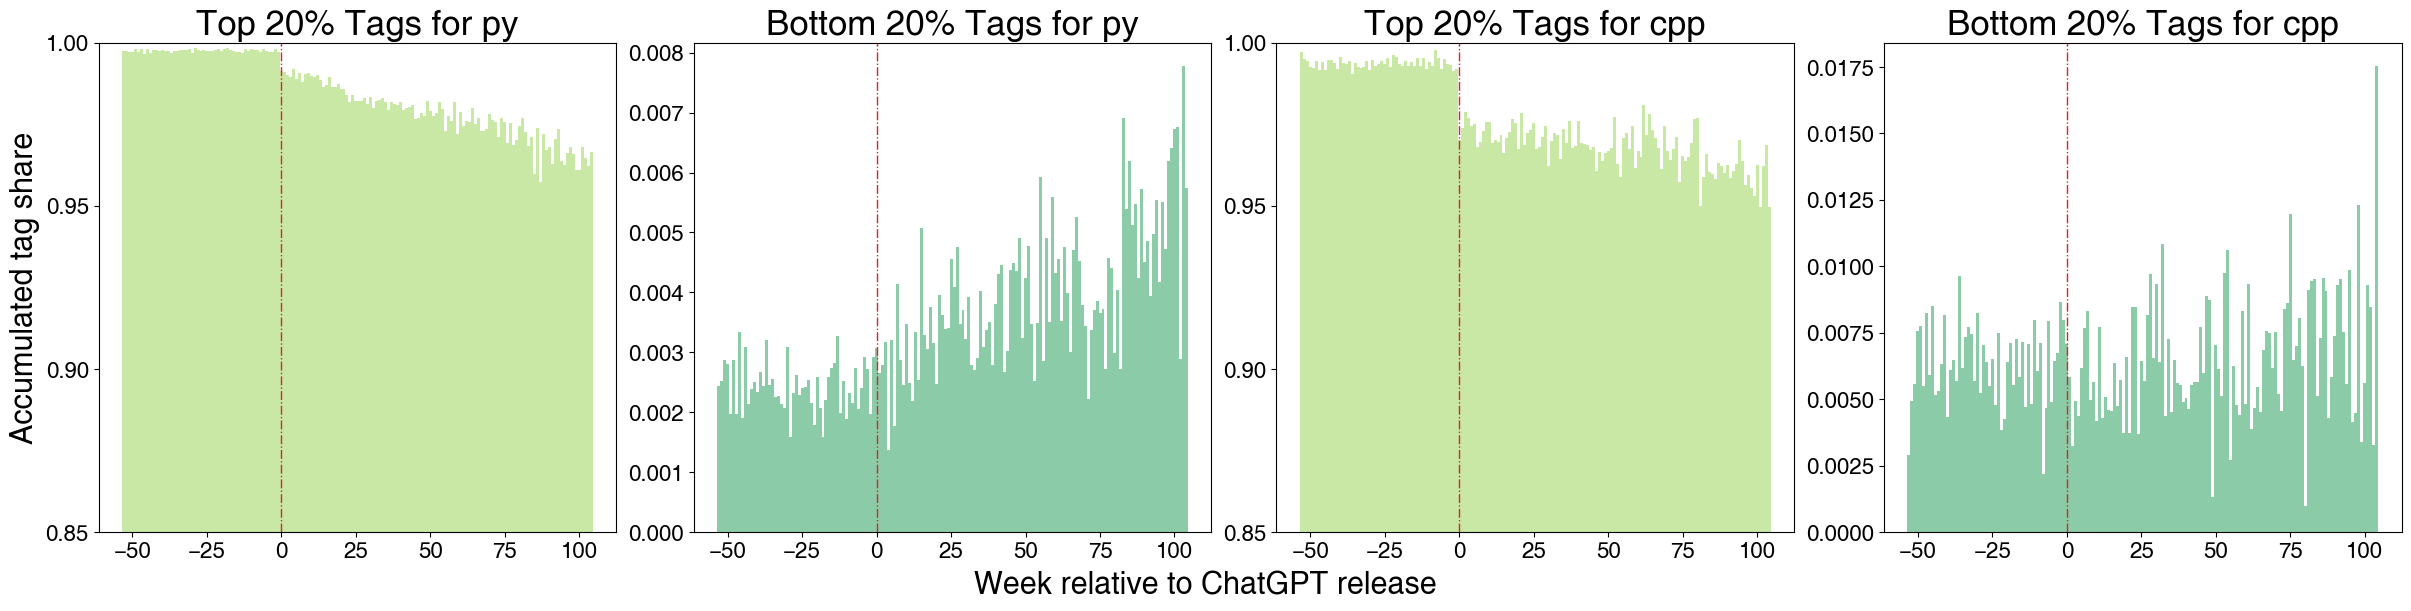

In [34]:
sharey = False ## 또는 sharey=False
sharex = True ## 또는 sharex=False
g_num  = len(proportion_dict_py.items())

fig, axs = plt.subplots(1, 4, figsize = (24, 6), constrained_layout=True)
alpha_list = [0.6, 0.5]
color_list = ["#a6d96a", "#1a9850"]

for x, (title, proportion) in enumerate(proportion_dict_py.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])
    
    axs[x].bar(rel_week, values, color=color_list[x], width=1.0, align='center', alpha=alpha_list[x]
    )
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)


    if x ==0 :
        axs[x].set_ylim(0.85, 1.0)
        axs[x].set_yticks(np.arange(0.85, 1.01, 0.05))

    axs[x].set_title(f'{title} for py', fontsize=25)
    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)

for idx, (title, proportion) in enumerate(proportion_dict_cpp.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])

    idx+=2

    axs[idx].bar(rel_week, values, color=color_list[idx-2], width=1.0, align='center', alpha=alpha_list[idx-2]
    )
    axs[idx].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)

    if idx ==2 :
        axs[idx].set_ylim(0.85, 1.0)
        axs[idx].set_yticks(np.arange(0.85, 1.01, 0.05))

    axs[idx].set_title(f'{title} for cpp', fontsize=25)
    axs[idx].tick_params(axis='x', labelsize=16)
    axs[idx].tick_params(axis='y', labelsize=16)

axs[0].set_ylabel("Accumulated tag share", fontsize = 22)

fig.supxlabel("Week relative to ChatGPT release", fontsize=22) 
plt.savefig(f"{output_dir}C_Result_Fig2_1.png", dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
tag_info = "../../visualization/result/tag/tag_info.json"
# difficulty가 없는 데이터로 ....경향성만 체크 
tag_dir = f'../../visualization/{CONSTANTS.tag_monthly_data_dir[3:]}'
output_dir = './fig/'

In [ ]:
print(tag_dir)

In [ ]:
tag_distributions = collect_tag_distributions(window=7,
                                            tag_info = tag_info,
                                            data_dir=tag_dir,
                                            options=None)
    

In [ ]:
# with open(f"weekly_tag_distributions.pkl","wb") as f:
#     pickle.dump(tag_distributions, f)

In [ ]:
with open("weekly_tag_distributions.pkl","rb") as f:
    tag_distributions = pickle.load(f)

In [ ]:
ginis = list(map(lambda x: calculate_gini(list(x.values())), tag_distributions))

In [ ]:
entropies = list(map(lambda x: calculate_entropy(list(x.values())), tag_distributions))

In [ ]:
gini_entropy_dict = {'Gini Coefficient' : ginis, 'Entropy' : entropies}

In [ ]:
rel_week = np.array(np.arange(-52, 52))

In [ ]:
st_0 = st.Stats(rel_week, entropies, 2, 0.95)

In [ ]:
F_stat_0, p_value_0 = st_0.chow_test()

In [ ]:
print(F_stat_0)

In [ ]:
print(f'{p_value_0:.3f}')

In [ ]:
sharey = False ## 또는 sharey=False
sharex = True ## 또는 sharex=False
g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, 3, figsize = (18, 6), constrained_layout=True)
alpha_list = [0.6, 0.5]
color_list = ["#a6d96a", "#1a9850"]

for x, (title, proportion) in enumerate(proportion_dict.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])
    
    axs[x].bar(rel_week, values, color=color_list[x], width=1.0, align='center', alpha=alpha_list[x]
    )
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)

    if x ==0 :
        axs[x].set_ylim(0.85, 1.0)
        axs[x].set_yticks(np.arange(0.85, 1.01, 0.05))

    # axs[x].set_title(f'{title}', fontsize=25)

    axs[x].text(0.5, 1.05, f"{title}",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[x].transAxes)

    axs[x].text(0.5, 1.00, "",
        ha='center', va='bottom', fontsize=15, transform=axs[x].transAxes)  
    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)


# for idx, measure in enumerate(gini_entropy_dict.keys()):
#     idx+=2
# entropy만 시각화
idx = 2
list_ = gini_entropy_dict['Entropy']
x_rel, divider = get_dist_x_div(list_)

reg_bf = calc_regression_with_ci(x_rel[:divider], list_[:divider])
reg_af = calc_regression_with_ci(x_rel[divider:], list_[divider:])

reg_bf_summary = reg_bf["pred_summary"]
reg_af_summary = reg_af["pred_summary"]

# 회귀선 (예측값)
reg_bf_y_pred = reg_bf_summary["mean"]
reg_af_y_pred = reg_af_summary["mean"]
# 신뢰구간
reg_bf_ci_lower = reg_bf_summary["mean_ci_lower"]
reg_bf_ci_upper = reg_bf_summary["mean_ci_upper"]

reg_af_ci_lower = reg_af_summary["mean_ci_lower"]
reg_af_ci_upper = reg_af_summary["mean_ci_upper"]

p_value_txt = '($p < 0.001$)' if p_value_0 <0.001 else '($p = {p_value_0:.3f}$)'

axs[idx].scatter(x_rel, list_, color = 'darkgray', alpha = 0.7,  s=10, marker='x')
axs[idx].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
# axs[idx].set_ylabel(f"{measure} of Topic Distribution", fontsize = 10)
axs[idx].plot(x_rel[:divider], reg_bf_y_pred, linewidth=2, label = 'before ChatGPT')
axs[idx].plot(x_rel[divider:], reg_af_y_pred, linewidth=2, label = 'after ChatGPT')

axs[idx].fill_between(x_rel[:divider], reg_bf_ci_lower, reg_bf_ci_upper, alpha=0.1)
axs[idx].fill_between(x_rel[divider:], reg_af_ci_lower, reg_af_ci_upper, alpha=0.1)

axs[idx].legend(frameon=False, loc='best', fontsize=14)
# axs[idx].set_title(f"Changes in Entropy (tag)", fontsize=25)
axs[idx].text(0.5, 1.05, f"Changes in Entropy (tag)",
            ha='center', va='bottom', fontsize=22, fontweight='bold', transform=axs[idx].transAxes)

axs[idx].text(0.5, 1.00, f"{p_value_txt}",
        ha='center', va='bottom', fontsize=15, transform=axs[idx].transAxes)  
# axs[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

axs[idx].tick_params(axis='x', labelsize=16)
axs[idx].tick_params(axis='y', labelsize=16)


    # axs[idx].fill_between(event_effects_dict[measure]['period'], event_effects_dict[measure]['ll_95'], event_effects_dict[measure]['ul_95'], color='#CFCFCF', alpha=0.4)
    # axs[idx].plot(event_effects_dict[measure]['period'], event_effects_dict[measure]['Estimate'], color='black', label='DID Estimate')

    # # 기준선
    # axs[idx].axhline(0, linestyle='--', color='black')
    # axs[idx].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

    # # 축 라벨과 제목
    # axs[idx].set_title(f"{measure}", fontsize=25)
    # # axs[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # axs[idx].tick_params(axis='x', labelsize=16)
    # axs[idx].tick_params(axis='y', labelsize=16)
    # axs[idx].set_ylim(-0.08, 0.12)
    # axs[idx].set_yticks(np.arange(-0.08, 0.12, 0.03))

axs[0].set_ylabel("Accumulated tag share", fontsize = 22)
axs[2].set_ylabel(f"Entropy", fontsize = 22)

fig.supxlabel("Weeks relative to ChatGPT release", fontsize=22) 
plt.savefig(f"{output_dir}C_Result_Fig2_2.png", dpi=300, bbox_inches='tight')
plt.show();